In [1]:
import SimpleITK as sitk
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import measure
%matplotlib inline

In [2]:
BASE_PATH = Path("/Volumes/DATASETS/LUNA/")
CT_SCAN_FORMAT = ".nii.gz"
LUNG_MASK_FORMAT = ".nii.gz"
NODULE_MASK_FORMAT = ".nii.gz"
ANNOTATIONS = BASE_PATH / "CSVFILES/annotations.csv"

In [3]:
df = pd.read_csv(ANNOTATIONS)
df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [4]:
def get_id_luna_image(path, fmt):
    return str(path).split("/")[-1].split(fmt)[0]

ct_scans = {get_id_luna_image(p, CT_SCAN_FORMAT): p for p in BASE_PATH.glob("equalized_spacing/*" + CT_SCAN_FORMAT)}
lung_masks = {get_id_luna_image(p, LUNG_MASK_FORMAT): p for p in BASE_PATH.glob("equalized_spacing_lung_masks/*" + LUNG_MASK_FORMAT)}
nodule_masks = {get_id_luna_image(p, NODULE_MASK_FORMAT): p for p in BASE_PATH.glob("equalized_spacing_nodule_masks/*" + NODULE_MASK_FORMAT)}

In [5]:
row = df.iloc[4]
img = sitk.ReadImage(str(ct_scans[row.seriesuid]))
img_mask_arr = sitk.GetArrayFromImage(sitk.ReadImage(str(lung_masks[row.seriesuid]))) > 0

In [6]:
print(img.GetDepth(), img.GetWidth(), img.GetHeight())
point = (row.coordX, row.coordY, row.coordZ)
print(img.GetSpacing())

321 285 285
(1.0, 1.0, 1.0)


In [7]:
ALPHA = 0.9
COLOR = 'r'

def display_nodule_contour(ax, nodule_mask, color=COLOR):
    contours = measure.find_contours(nodule_mask, 0.8)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color=color, alpha=ALPHA)

def display_nodule(row, ct_scans, lung_masks, nodule_masks, apply_mask=True):
    img = sitk.ReadImage(str(ct_scans[row.seriesuid]))
    img_mask = sitk.ReadImage(str(lung_masks[row.seriesuid]))
    img_nodule = sitk.ReadImage(str(nodule_masks[row.seriesuid]))
    img_arr = sitk.GetArrayFromImage(img)
    img_mask_arr = sitk.GetArrayFromImage(img_mask) > 0
    img_nodule_mask_arr = sitk.GetArrayFromImage(img_nodule) > 0
    if apply_mask:
        img_arr *= img_mask_arr
    point = (row.coordX, row.coordY, row.coordZ)
    X_idx, Y_idx, Z_idx = img.TransformPhysicalPointToIndex(point)
    X_max, Y_max, Z_max = reversed(img_arr.shape)
    X_spacing, Y_spacing, Z_spacing = img.GetSpacing()
    
    f, axarr = plt.subplots(2, 2, figsize=(20,20))
    
    axarr[0,1].set_title("nodule properties\n\n")
    axarr[0,1].text(
        0.10, 0.55,
        'Nodule coordinates (X,Y,Z) (voxels): (%d, %d, %d)' % (X_idx, Y_idx, Z_idx),
        fontsize=15
    )
    axarr[0,1].text(
        0.10, 0.45,
        'Nodule diameter (mm): %f' % (row.diameter_mm,),
        fontsize=15
    )
    axarr[0,1].axes.get_xaxis().set_visible(False)
    axarr[0,1].axes.get_yaxis().set_visible(False)
    
    axarr[0,0].xaxis.tick_top()
    axial_plane = img_arr[Z_idx, :, :]
    print("Axial plane shape:", axial_plane.shape)
    display_nodule_contour(axarr[0,0], img_nodule_mask_arr[Z_idx, :, :])
    axarr[0,0].imshow(axial_plane, cmap='gray')
    axarr[0,0].plot([X_idx, X_idx], [0, Y_max], color=COLOR, linestyle='-', linewidth=1, alpha=ALPHA)
    axarr[0,0].plot([0, X_max], [Y_idx, Y_idx], color=COLOR, linestyle='-', linewidth=1, alpha=ALPHA)
    axarr[0,0].set_title("axial plane\n\n")
    axarr[0,0].set_xlabel("X axis")
    axarr[0,0].set_ylabel("Y axis")
    
    aspect_ratio = Z_spacing / X_spacing
    print("Coronal aspect ratio is:", aspect_ratio)
    axarr[1,0].xaxis.tick_top()
    coronal_plane = img_arr[:, Y_idx, :]
    print("Coronal plane shape:", coronal_plane.shape)
    display_nodule_contour(axarr[1,0], img_nodule_mask_arr[:, Y_idx, :])
    axarr[1,0].imshow(coronal_plane, cmap='gray')
    axarr[1,0].plot([X_idx, X_idx], [0, Z_max], color=COLOR, linestyle='-', linewidth=1, alpha=ALPHA)
    axarr[1,0].plot([0, X_max], [Z_idx, Z_idx], color=COLOR, linestyle='-', linewidth=1, alpha=ALPHA)
    axarr[1,0].set_xlabel("X axis")
    axarr[1,0].set_ylabel("Z axis")
    axarr[1,0].set_aspect(aspect_ratio)
    axarr[1,0].set_title("coronal plane\n\n")

    aspect_ratio = Z_spacing / Y_spacing
    print("Sagittal aspect ratio is:", aspect_ratio)
    axarr[1,1].xaxis.tick_top()
    sagittal_plane = img_arr[:, :, X_idx]
    print("Sagittal plane shape:", sagittal_plane.shape)
    display_nodule_contour(axarr[1,1], img_nodule_mask_arr[:, :, X_idx])
    axarr[1,1].imshow(sagittal_plane, cmap='gray')
    axarr[1,1].plot([Y_idx, Y_idx], [0, Z_max], color=COLOR, linestyle='-', linewidth=1, alpha=ALPHA)
    axarr[1,1].plot([0, Y_max], [Z_idx, Z_idx], color=COLOR, linestyle='-', linewidth=1, alpha=ALPHA)
    axarr[1,1].set_title("sagittal plane\n\n")
    axarr[1,1].set_xlabel("Y axis")
    axarr[1,1].set_ylabel("Z axis")
    axarr[1,1].set_aspect(aspect_ratio)
    
    plt.suptitle('3 plane view of nodule in scan ' + row.seriesuid, fontsize=20)
    
    plt.show()

Axial plane shape: (330, 330)
Coronal aspect ratio is: 1.0
Coronal plane shape: (349, 330)
Sagittal aspect ratio is: 1.0
Sagittal plane shape: (349, 330)


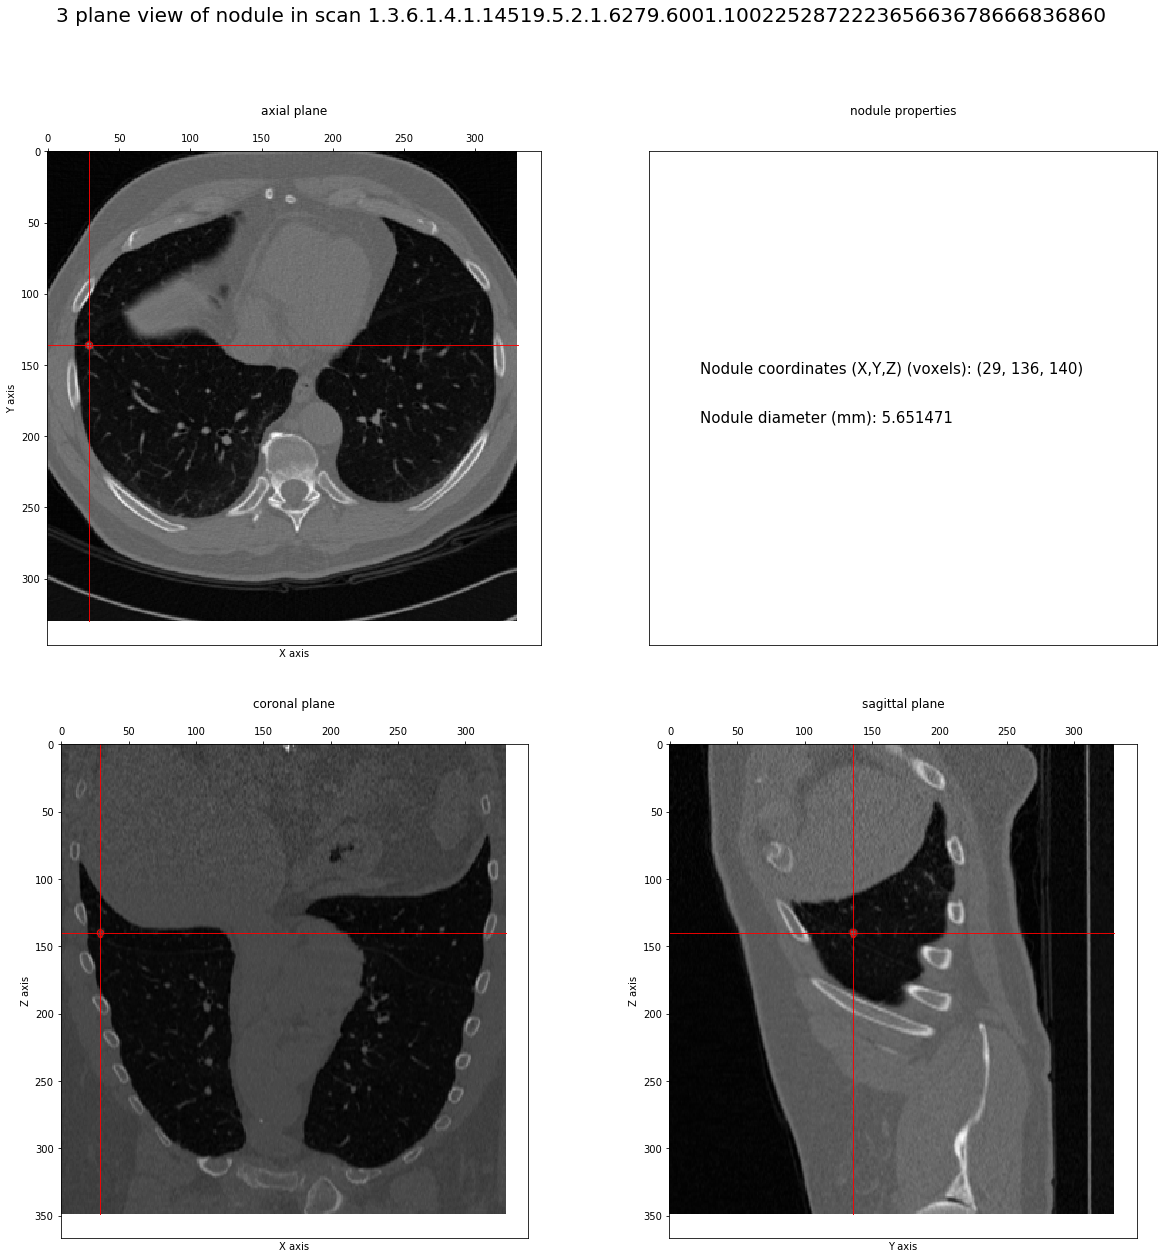

In [8]:
display_nodule(df.iloc[0], ct_scans, lung_masks, nodule_masks, False)

Axial plane shape: (285, 285)
Coronal aspect ratio is: 1.0
Coronal plane shape: (321, 285)
Sagittal aspect ratio is: 1.0
Sagittal plane shape: (321, 285)


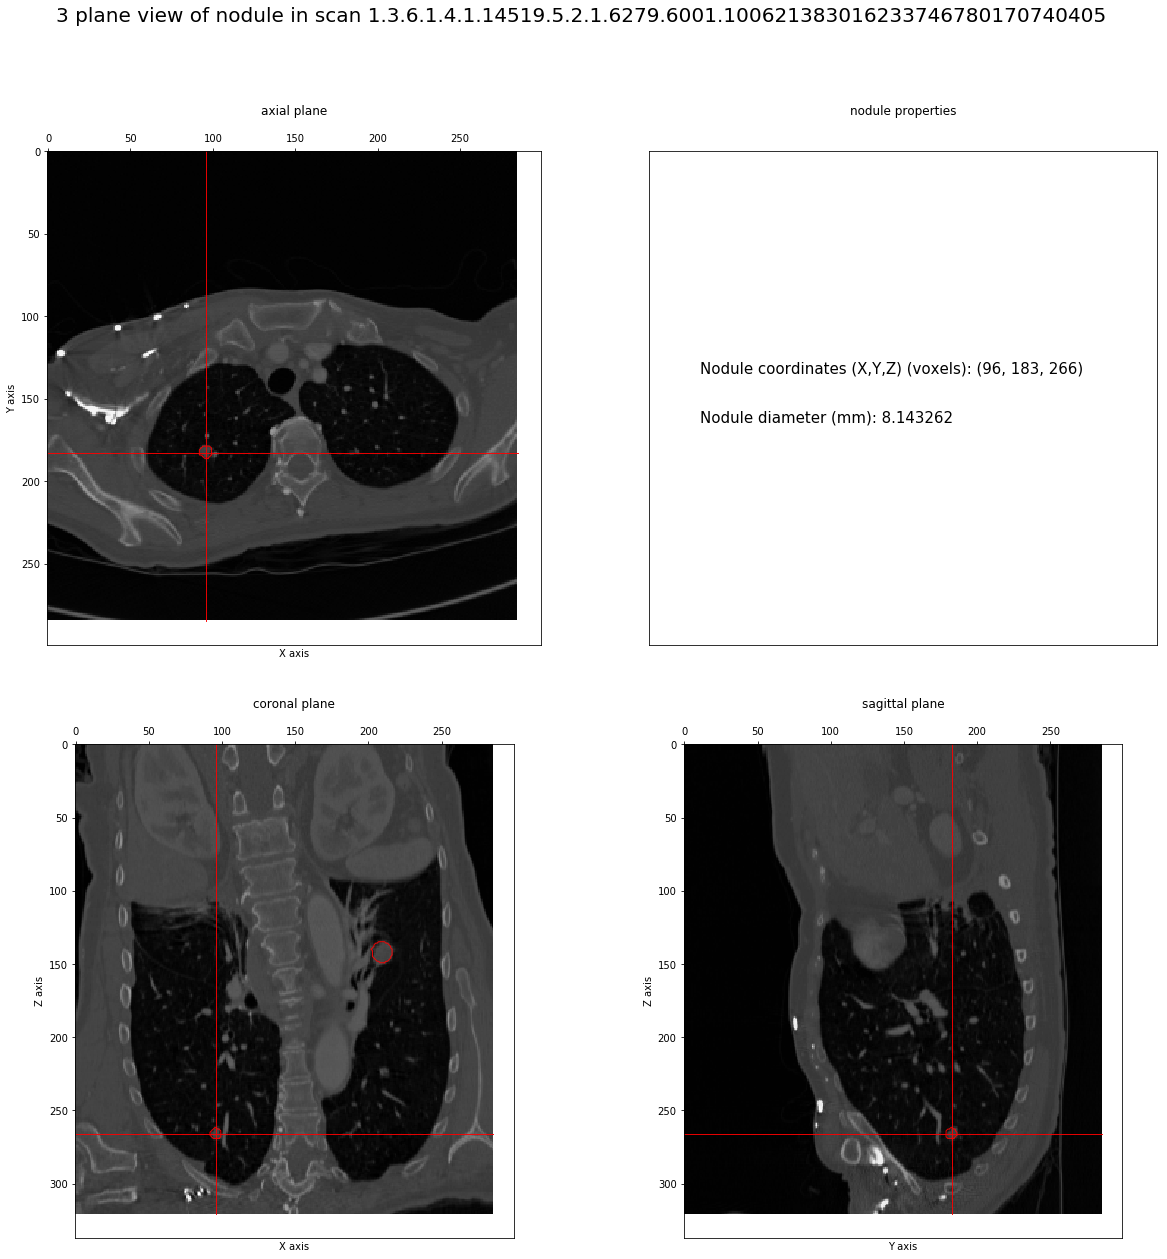

In [9]:
display_nodule(df.iloc[3], ct_scans, lung_masks, nodule_masks, False)

Axial plane shape: (285, 285)
Coronal aspect ratio is: 1.0
Coronal plane shape: (321, 285)
Sagittal aspect ratio is: 1.0
Sagittal plane shape: (321, 285)


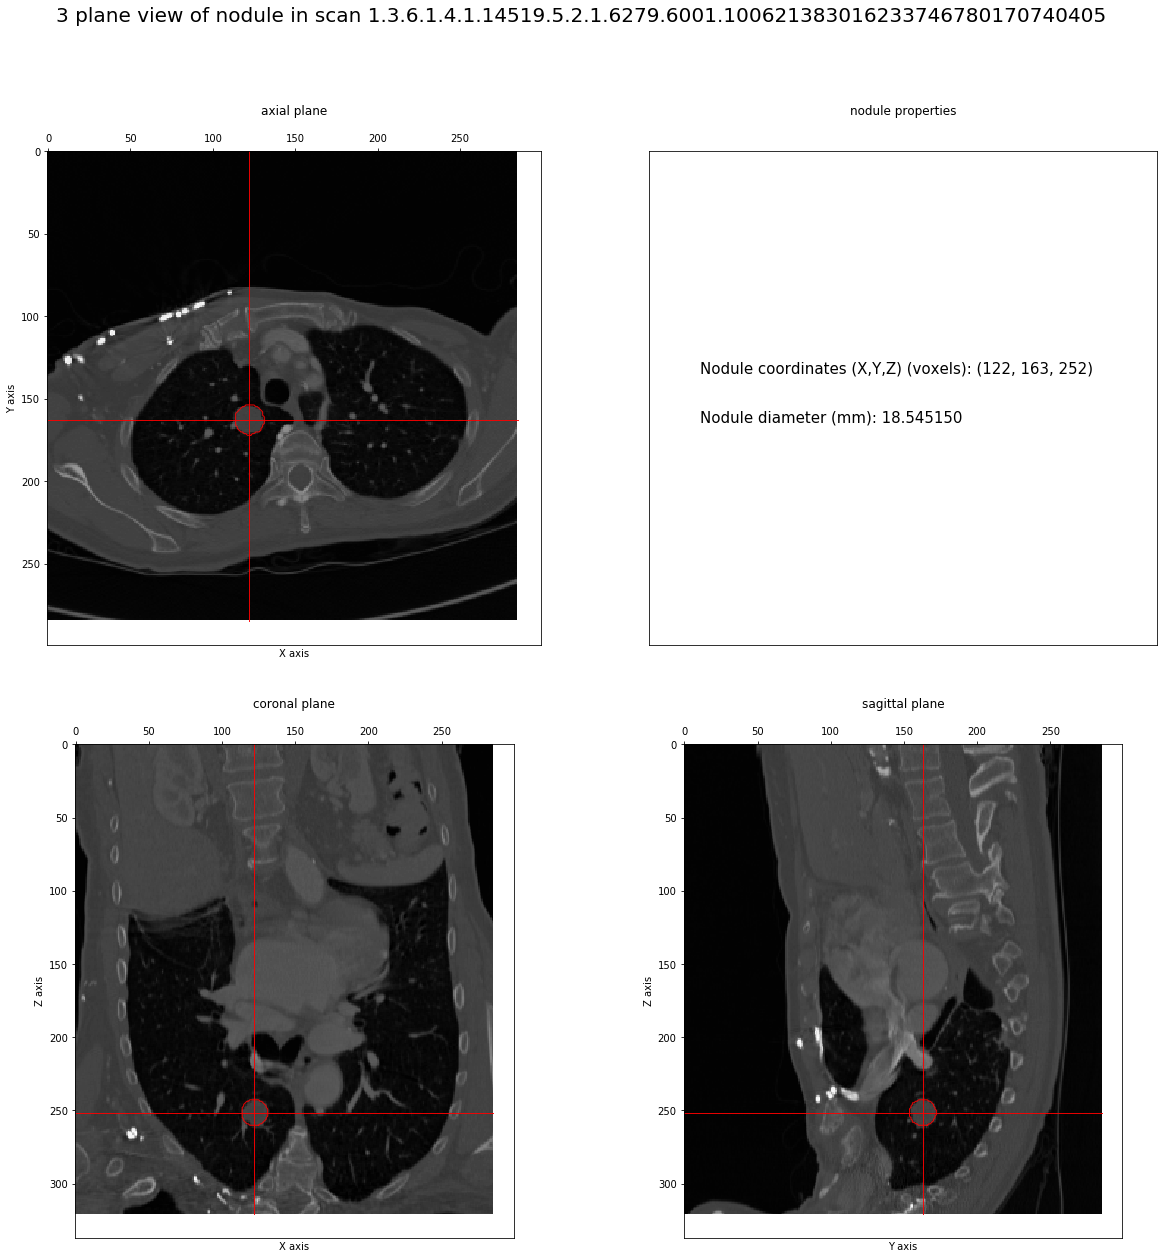

In [10]:
display_nodule(df.iloc[4], ct_scans, lung_masks, nodule_masks, False)

Axial plane shape: (472, 472)
Coronal aspect ratio is: 1.0
Coronal plane shape: (321, 472)
Sagittal aspect ratio is: 1.0
Sagittal plane shape: (321, 472)


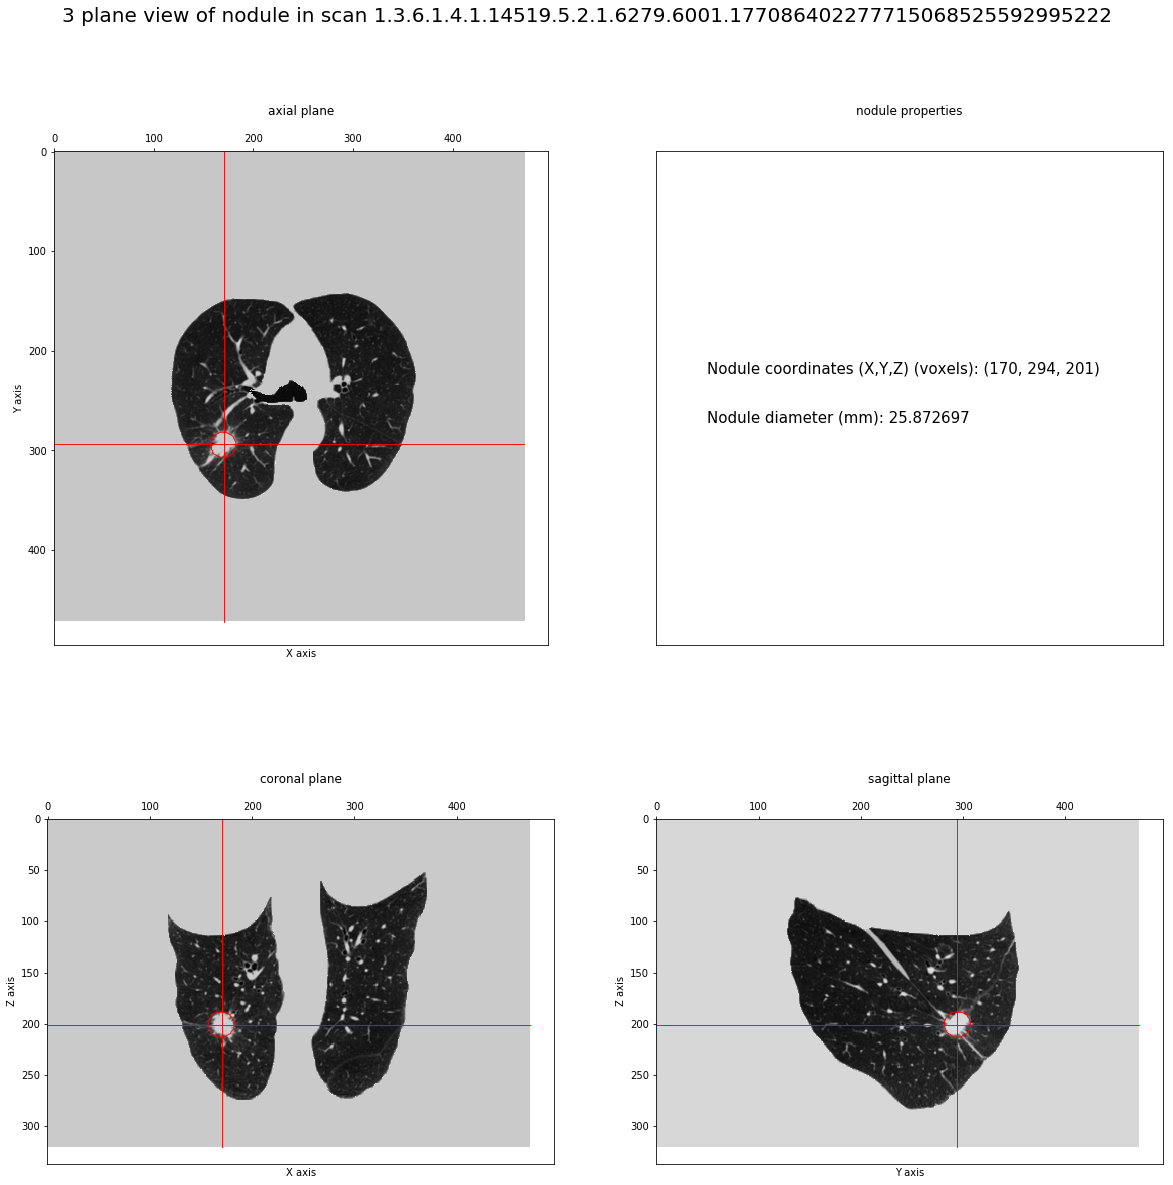

In [ ]:
display_nodule(df.iloc[300], ct_scans, lung_masks, nodule_masks, True)

In [ ]:
ids = []
shapes = []
for k,n in nodule_masks.items():
    img = sitk.ReadImage(str(n))
    img_arr = sitk.GetArrayViewFromImage(img)
    shapes.append(img_arr.shape)
    ids.append(k)
shapes = np.array(shapes)

In [ ]:
print("min", shapes.min(axis=0))
print("max", shapes.max(axis=0))
print("min indices", shapes.argmin(axis=0))
print("max indices", shapes.argmax(axis=0))
print("mean", shapes.mean(axis=0))

In [ ]:
print(ids[165])
print(ids[487])
print(ids[57])

In [ ]:
row = df[df["seriesuid"] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681'].iloc[0]
display_nodule(row, ct_scans, lung_masks, nodule_masks, True)

In [ ]:
row = df[df["seriesuid"] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.199261544234308780356714831537'].iloc[0]
display_nodule(row, ct_scans, lung_masks, nodule_masks, True)

In [ ]:
row = df[df["seriesuid"] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196'].iloc[0]
display_nodule(row, ct_scans, lung_masks, nodule_masks, True)